In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2
import numpy as np
import pandas as pd
import glob, re, sys

from finding_colored_balls import find_balls_in_image, ball_colors_bgr

E_K    = np.load('./calib/Ei/K.npy')
E_dist = np.load('./calib/Ei/dist.npy')
E_rvec = np.load('./calib/Ei/rvec.npy')
E_tvec = np.load('./calib/Ei/tvec.npy')

W_K    = np.load('./calib/Wi/K.npy')
W_dist = np.load('./calib/Wi/dist.npy')
W_rvec = np.load('./calib/Wi/rvec.npy')
W_tvec = np.load('./calib/Wi/tvec.npy')

E_proj = np.dot(E_K, np.concatenate((cv2.Rodrigues(E_rvec)[0], E_tvec), axis=1))
W_proj = np.dot(W_K, np.concatenate((cv2.Rodrigues(W_rvec)[0], W_tvec), axis=1))

In [2]:
get_float = lambda x : float(re.sub(r".*/0*(.*)_[EW].jpg", r"\1", str(x)))


df = {}
for cam in "EW":
    files = glob.glob("img/hello_3D/raw/*{}.jpg".format(cam))

    df[cam] = pd.DataFrame({"file" : files})
    df[cam]["time"] = df[cam]["file"].apply(get_float)
    
df = pd.merge_asof(df["E"], df["W"], on = "time", suffixes = ("_E", "_W"))# [["file_E", "file_W"]]


for cam in "EW":
    df["time_" + cam] = df["file_" + cam].apply(get_float)

df.dropna(inplace = True)

# df = df[:100].copy()

In [3]:
Exy = df.file_E.apply(find_balls_in_image, args = ("circles", 40))
Wxy = df.file_W.apply(find_balls_in_image, args = ("circles", 40))

df["Ex"] = [x[0][0] if len(x) else np.nan for x in Exy]
df["Ey"] = [x[0][1] if len(x) else np.nan for x in Exy]

df["Wx"] = [x[0][0] if len(x) else np.nan for x in Wxy]
df["Wy"] = [x[0][1] if len(x) else np.nan for x in Wxy]

df.dropna(inplace = True)

In [4]:
red_points = cv2.triangulatePoints(E_proj, W_proj, 
                                   df[["Ex", "Ey"]].T.values, 
                                   df[["Wx", "Wy"]].T.values)

red_points /= red_points[3] # homogeneous to euclidean

for ci, c in enumerate("xyz"): 
    df[c + "0"] = red_points[ci]
    df[c + "1"] = df[c + "0"].shift(-1)

df.reset_index(drop = True, inplace = True)

In [5]:
df_hello = df[(df.time > 13) & (df.time < 37)].copy() 
xctr, yctr, zctr = df_hello[["x0", "y0", "z0"]].mean()
df_hello["x0"] -= xctr
df_hello["y0"] -= yctr
df_hello["z0"] -= zctr

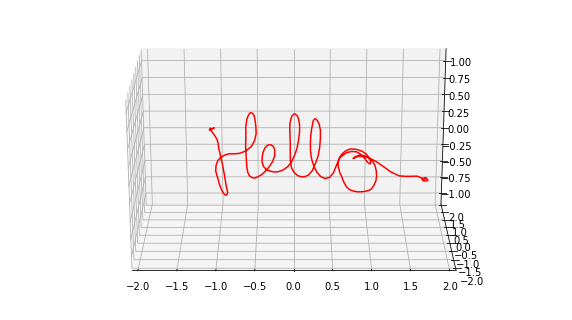

In [6]:
size = 10
zx_fact = 540 / 960

fig, ax = plt.subplots(figsize = (size, size * zx_fact), subplot_kw = {'projection': '3d'})
    
    
ax.plot(xs = df_hello.x0, ys = df_hello.y0, zs = df_hello.z0, color = "red")

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2 * zx_fact, 2 * zx_fact)

for a in range(90, 271, 10):
    ax.view_init(elev = 20, azim = a)
    fig.savefig("img/hello_3D/spin/{:03d}.png".format(a))
    
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# ax.set_axis_off()


# ax.view_init(elev = 20, azim = 270)
